# LikeToHear AI
liketohear-ai is a prototype that was created in the course of the Hack4Ear Hackathon, organized by Fraunhofer IDMT. It is a first draft for the automatic self-fitting of hearing aids. The device learns from the user's feedback and makes suggestions for different sound situations.

**How it works**

To adjust the listening experience, the user uses the new liketohear technology, with which he can conveniently adjust parameters such as gain and timbre using the mobile phone app.

A machine learning model learns from this feedback and gives the user more and more suitable suggestions over time by learning from his preferences for corresponding situations.

## First Data analysis of spectral data

### Data Preparation


In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

def get_decibels(msg):
    if "RMS level in dB" in msg:
        decibels_str_list=re.findall("\\[[^\\]]*]",msg)[0][1:-1].split()
        decibels={str(k+1):float(v) for (k,v) in enumerate(decibels_str_list)}
        decibels["sum"]=sum(decibels.values())
    else:
        print("unknown message: "+str(msg))
        decibels={}
    return decibels
    
def parse_file(file):
    with open(file) as f:
        j=json.load(f)
        
    measures=[]
    cur_presetx=0
    cur_presety=0
    cur_el={}
    for el in j:
        if "data" in el:
            if "presetx" in el["data"] and "presety" in el["data"]:
                cur_el["presetx"]=el["data"]["presetx"]
                cur_el["presety"]=el["data"]["presety"]
                measures+=[cur_el]    
            else: #intensity data
                decibels=get_decibels(el["msg"])
                el.update(decibels)
                cur_el=el
    return pd.DataFrame(measures)
        
            
            

In [7]:
df=pd.DataFrame(parse_file("liketohear_soundwalk_loggings/Results_2019-10-16/user_interface_2_nn04im02.log"))

df["date"]=pd.to_datetime(df["date"])
df.head()

unknown message: openMHACtrl started
unknown message: openMHACtrl started


,date,msg,userid,data,1,2,3,4,5,6,7,8,9,10,11,12,sum,presetx,presety
0,2019-10-02 09:52:11,# RMS level in dB\n# vector<float> (monitor)\n...,DefaultUser,[],-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.00000,-100.000000,-100.000000,-1200.000000,5,5
1,2019-10-02 09:52:12,# RMS level in dB\n# vector<float> (monitor)\n...,DefaultUser,[],-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.00000,-100.000000,-100.000000,-1200.000000,5,5
2,2019-10-02 09:52:13,# RMS level in dB\n# vector<float> (monitor)\n...,DefaultUser,[],-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.00000,-100.000000,-100.000000,-1200.000000,5,5
3,2019-10-02 09:52:14,# RMS level in dB\n# vector<float> (monitor)\n...,DefaultUser,[],-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.00000,-100.00000,-100.000000,-100.000000,-1200.000000,5,5
4,2019-10-02 09:52:15,# RMS level in dB\n# vector<float> (monitor)\n...,DefaultUser,[],17.363678,10.057733,9.277719,13.721788,16.203148,22.329435,15.861055,11.072513,9.67792,15.63076,16.297939,22.318487,179.812178,5,5


## Results Analysis

Show unique user IDs contained in the dataset.

In [8]:
print("Unique users Ids")
set(df["userid"])

Unique users Ids


{'DefaultUser', 'Test-home', 'nn04im02'}

In [9]:
user_df=df[df["userid"]=="nn04im02"]


In [10]:
def plot_timeseries(user_df):
    channel="5"
    plt.subplot(411)
    plt.title("Input - Intensity Value for channel "+channel)
    plt.plot(user_df["date"],user_df[channel])
    plt.tight_layout()
    #plt.show()
    plt.subplot(412)
    plt.plot(user_df["date"],user_df["presetx"])
    plt.title("Response - X Value (tonal color)")
    plt.subplot(413)
    plt.title("Response - Y Value (Amplification)")
    plt.plot(user_df["date"],user_df["presety"])

    plt.subplot(414)
    from scipy.signal import savgol_filter
    y_smooth = savgol_filter(user_df["5"], 51, 2)
    plt.plot(user_df["date"],y_smooth)
    
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    fig.savefig('timeseries.png', dpi=120)

    
def plot_details(users):
    for user in users:
        user_df=df[df["userid"]==user]
        plot_timeseries(user_df)


/home/john/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


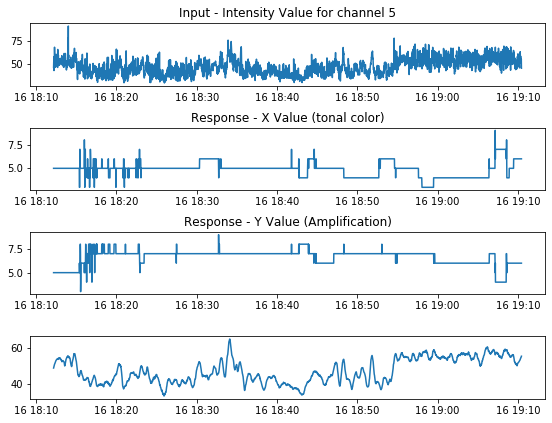

In [11]:
plot_details(["nn04im02"])

The X and Y time series plots seem to be correlated. The dynamics of the response evolves on multiple timescales.

### Relation Analysis of Spectrogram and Responses

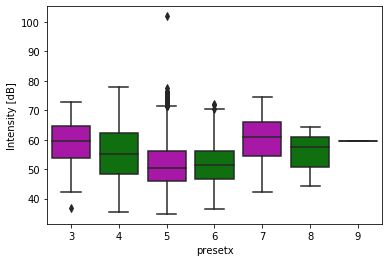

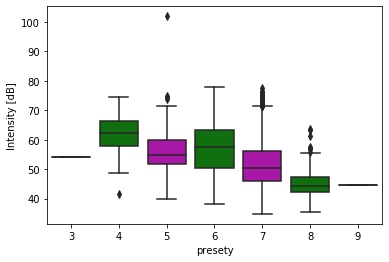

In [13]:
def draw_box_plot():
    pass

from sklearn.preprocessing import RobustScaler
x = user_df[["sum","presetx","presety"]].values #returns a numpy array
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled,columns=["5","presetx","presety"])

sns.boxplot(x="presetx",y="4",palette=["m", "g"],
            data=user_df)
plt.ylabel("Intensity [dB]")
fig = plt.gcf()
fig.savefig('boxplotx.png', dpi=100)
plt.show()

sns.boxplot(x="presety",y="4",palette=["m", "g"],
            data=user_df)
plt.ylabel("Intensity [dB]")
fig = plt.gcf()
fig.savefig('boxploty.png', dpi=100)
plt.show()

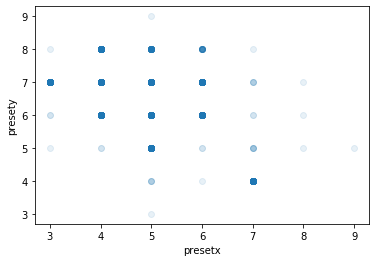

In [14]:
plt.plot(user_df["presetx"],user_df["presety"],'o',alpha=.1)
plt.xlabel("presetx")
plt.ylabel("presety")

plt.show()

## Visualization of spectrogram

In [15]:
bands=[]
intensities=[]
dates=[]

def flatten(l):
    return sum(l,[])

for band in range(1,12):
    intensities+=[user_df[str(band)].values]
    bands+=[[band]*len(user_df[str(band)].values)]
    dates+=[range(len(user_df))]

    
intensities=np.array(intensities).flatten()
bands=np.array(bands).flatten()
dates=np.array(dates).flatten()

tmp_df=pd.DataFrame({"intensities":intensities,"bands":bands,"dates":dates})
pv=tmp_df.pivot("bands","dates","intensities")




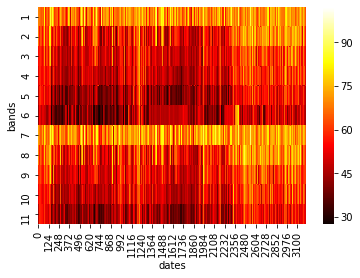

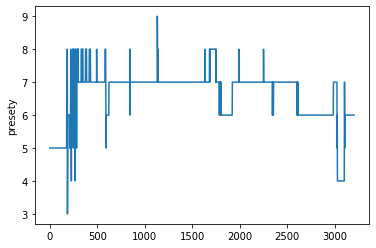

In [16]:
#fig, ax = plt.subplots(2,1, sharex=True)

#ax1=plt.subplot(211)
sns.heatmap(pv,cmap="hot")


#ax2 = plt.subplot(212,sharex=ax1)
#fig = plt.gcf()
#fig.set_size_inches(20,7)

#plt.subplot(212)
plt.show()
sns.lineplot(range(len(user_df["date"])),user_df["presety"])
#ax2.plot(range(len(user_df["date"])),user_df["5"])

### Regression Analysis for Self-Fitting of the user

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

X=user_df[["1","2","3","4","5","6","7","8","9"]]
#X=user_df[["5","5"]]
y=user_df["presety"]

X_train=X.iloc[:2000]
y_train=y.iloc[:2000]
X_test=X.iloc[2000:]
y_test=y.iloc[2000:]

#model=DecisionTreeRegressor(max_depth=2)
linear_model=RidgeCV(normalize=True)
linear_model.fit(X_train,y_train)
linear_model.score(X_test,y_test)

Plotting the coefficients of the linear, resembling the relevance of different frequency bands.

In [ ]:
plt.bar(range(len(linear_model.coef_)),linear_model.coef_)


/home/john/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Feature Importances')

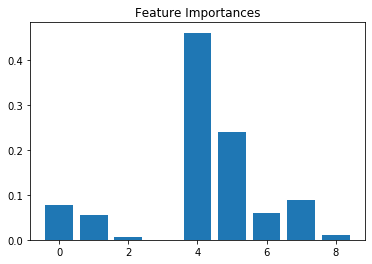

In [20]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(max_depth=3)
model.fit(X_train,y_train)
imps=model.feature_importances_
plt.bar(range(len(imps)),imps)
plt.title("Feature Importances")

The feature importance clearly shows the relevance of channels 5,6 which also evident if we look at the pairplot of spectrogram and time series.

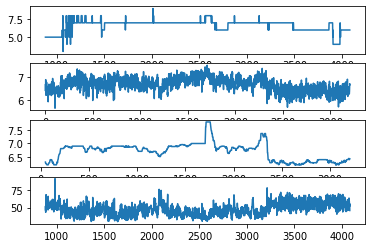

In [21]:
plt.subplot(411)
plt.plot(y)
plt.subplot(412)
plt.plot(linear_model.predict(X))
plt.subplot(413)
#plt.plot(savgol_filter(model.predict(X),51,2))
plt.plot(pd.Series(model.predict(X)).rolling(50).median())
plt.subplot(414)
plt.plot(user_df["5"].iloc[:])

In [82]:
from scipy.signal import savgol_filter
y_smooth = savgol_filter(model.predict(X), 31, 2)

# Liketohear-ai Prototype 

In [23]:
from paramiko import SSHClient
client = SSHClient()
client.load_system_host_keys()
client.connect('172.24.1.1',username="pi",password="liketohear")
stdin, stdout, stderr = client.exec_command('ls -l')

TimeoutError: [Errno 110] Connection timed out

In [ ]:
sftp_client = client.open_sftp()
f = sftp_client.open("/media/user_interface.log")

lastLine = None

f.read().decode("utf-8") 
1

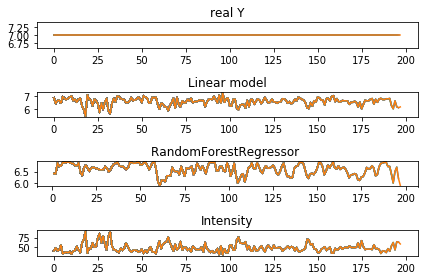

hi


/home/john/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/john/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/john/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

text=""

while True:
    #time.sleep(5)
    line =f.read().decode("utf-8") 
    text+=line
    
    tmp_text="["+text+"]"
    tmp_text=tmp_text.replace("}\n{","},{")
    print("hi")
    
    j=json.loads(tmp_text)
    

    measures=[]
    cur_presetx=0
    cur_presety=0
    cur_el={}
    for el in j:
        if "data" in el:
            if "presetx" in el["data"] and "presety" in el["data"]:
                cur_el["presetx"]=el["data"]["presetx"]
                cur_el["presety"]=el["data"]["presety"]
                measures+=[cur_el]    
            else: #intensity data
                decibels=get_decibels(el["msg"])
                el.update(decibels)
                cur_el=el
    df=pd.DataFrame(measures)
    user_df=df[df["userid"]=="d"]
    df["date"]=pd.to_datetime(df["date"])

    X=user_df[["1","2","3","4","5","6","7","8","9"]]
    y=user_df["presety"]

    #pred=model.predict(X)
    
    plt.tight_layout()
    plt.subplot(411)
    plt.title("real Y")
    plt.plot(y)
    plt.subplot(412)
    plt.title("Linear model")
    plt.plot(linear_model.predict(X))
    plt.subplot(413)
    plt.title("RandomForestRegressor ")
    #plt.plot(savgol_filter(model.predict(X),51,2))
    plt.plot(pd.Series(model.predict(X)).rolling(2).median())
    #plt.plot(pd.Series(model.predict(X)))
    
    plt.subplot(414)
    plt.title("Intensity")
    plt.plot(user_df["5"].iloc[:])
    #plt.show()
    display.clear_output(wait=True)
    display.display(pl.gcf())
    

In [93]:
df

,date,msg,userid,data,1,2,3,4,5,6,7,8,9,10,11,12,sum,presetx,presety
0,2019-11-09 15:56:51,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],65.852035,69.837128,59.862526,53.487545,48.222893,49.841667,65.526916,68.325684,58.939091,52.024185,46.524422,46.575256,685.019348,5,5
1,2019-11-09 15:56:52,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],63.259468,63.094021,58.638168,53.444447,45.460400,37.623497,61.409740,62.466587,56.758747,52.017883,41.110313,36.029152,631.312424,5,5
2,2019-11-09 15:56:53,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],67.067268,58.859829,50.536915,50.886555,48.043270,43.733871,65.907288,55.539391,49.006958,50.042172,44.185905,41.764965,625.574387,5,5
3,2019-11-09 15:56:54,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],66.502602,66.080429,58.310089,55.978245,52.298332,47.910305,64.634666,65.947197,59.493465,52.698448,49.484501,44.768887,684.107166,5,5
4,2019-11-09 15:56:56,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],78.771492,70.445068,60.253105,57.956436,50.204372,46.625668,77.713783,70.183517,58.051186,57.175083,52.122116,45.033630,724.535458,5,5
5,2019-11-09 15:56:57,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],77.366409,73.326515,68.249466,58.804390,52.097774,49.516762,76.406746,72.447807,64.187729,56.595177,52.945023,44.562058,746.505856,5,5
6,2019-11-09 15:56:58,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],70.995521,67.828484,55.941834,50.490066,50.536114,49.254879,70.932175,67.818649,53.886623,50.742203,47.490688,47.606831,683.524067,5,5
7,2019-11-09 15:56:59,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],68.323357,74.102081,74.848831,60.962299,52.975155,50.416187,68.778320,72.274666,72.179092,56.549637,55.008827,44.171478,750.589931,5,5
8,2019-11-09 15:57:00,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],79.188789,61.998009,63.760471,55.482273,52.930664,45.807896,78.410484,61.695976,62.884247,57.855267,49.969727,42.656570,712.640373,5,5
9,2019-11-09 15:57:01,# RMS level in dB\n# vector<float> (monitor)\n...,d,[],69.689301,59.381020,60.401711,52.769222,48.087692,42.505669,69.171425,59.798065,58.336143,51.364342,47.287338,39.773933,658.565861,5,5


In [ ]:
# Thanks for the very good organization, 
# meet like-minded people
# Met a lot of interesting people, and am glad to 

x,y => (Poistion vom Bobbel auf der App)
x  .. mehr Höen
y .. Lautstärken

Was will manwissen:
    * Lautstärke vor Verstärkung
    
x,y in Abhängigkeit von Umgebungsssound

Gleiche Soundsituation -> Muster erkennen
Gleiche Soundsituationen ähnlich einstellen?

pro Logging und pro Person 

keine relative Zeit..